# Lesson 10 // Convolutional neural networks

---

Convolutional neural networks (CNNs) refer to a particular kind of neural network architecture that has proved enormously successful in dealing with data in which the input features exhibit some kind of spatial or temporal ordering. A surprisingly large number of data sets and applications fall into this category. For example:

- **Images** display spatial ordering. We expect pixel values in nearby pixels to be similar, and if they are not similar this tells us something valuable (for example, that we have encountered an edge)
- **Audio** or **acoustic** data displays temporal ordering. In music for example, the *sequence* of notes conveys important information. If you randomly reorder the notes in a symphony, you most likely end up with something that sounds very different, and very much worse, than the original. 
- **Text** data is also ordered "temporally", in the same way that audio is. We have seen that bag-of-words models can give good predictive results, but it would be no surprise to learn that better results can be obtained if we look at the order in which words are combined.
- **Video** data is both spatially and temporally ordered: it is a collection of images ordered through time.

CNNs are designed to exploit the structure of ordered data. Their fundamental building block is the *convolution filter*, a small matrix of coefficients or "mask" that is placed "on top" the ordered data and slid "along" the data in the direction given by the natural ordering. At each step, the coefficients in the convolution filter are multiplied with the data they are currently sitting on top of, and this multiplication can amplify or dampen the features in the data in a vast number of ways. This is the way CNNs extract "meaning" from data.

Each layer in a CNN consists of a user-specified number of these convolution filters, plus some additional operations and transformations. The output of one layer forms the input to the next. In this way the convolution filters in one layer operate on the outputs of convolution filters in the previous layer. In practice, this means that convolution filters in early layers tend to detect very simple patterns (like edges in images) and later layers combine these patterns into something much more elaborate (the letter "E", or a face, for example). For this reason most CNNs are deep CNNs - they have several hidden layers between their input and output layers.

This notebook shows you how to fit CNNs to data in R. As in the previous lesson, there are two main goals: **understanding** what is going on in a CNN, which we'll do by looking at a spreadsheet example, and **implementing** CNNs on a larger scale.

We use the **keras** R package to implement CNNs, which provides an interface with the Python library of the same name. As mentioned in the last lesson, the "main" keras library is written in Python. What the R package **keras** does is to create (within R) a virtual Python environment, from which Python commands - specifically those used by (Python) keras - can be executed. You won't see this happening - from the perspective of the R user, the commands you enter are all R functions from the R **keras** package, and the results are returned in the form of R objects. But it does mean that you need to have Python installed, and have your version of R correctly detecting your Python installation, in order to do anything. This can be a mild-to-moderate pain, depending on your operating system and (in my case) how many different versions of Python you have managed to accumulate over the years. 

The good news (sort of) is that in this lesson we're not going to be using our own computers very much at all. CNNs, and most modern neural networks, are massive computation machines. As we saw in the previous lesson the operations they carry out are quite simple, but the sheer number of operations means that in most cases and for most people fitting neural networks on your own computer is not a practical option - they may take weeks or longer to run.   

Fortunately, *graphics processing units* or GPUs are excellent at doing just the kinds of computations used by neural networks. So right now most large-scale applications of neural networks use *GPU-accelerated computing* - a GPU is used in conjunction with a CPU and those computations that are most efficiently run on GPUs are farmed out to the GPU. Neural network libraries like Theano and Tensorflow do this for you.

Most people don't have access to their own GPUs, but there are a number of cloud computing options that provide access (at a cost!) to GPU-accelerated computing. In this notebook we will set up our own GPU-based cloud server using Amazon EC2 (Elastic Compute Cloud) service, part of the broader Amazon Web Services. This basically involves setting up an "empty" web server (or choosing from a number of default options), installing the software you need, and accessing the server as and when you need to run your analyses. AWS calls a server an "instance".

> **WARNING!** Amazon EC2 has a number of different instance types, see [here](https://aws.amazon.com/ec2/instance-types/). Some instance types are free, but all the instance types using GPU computing **cost money**. Some costs are incurred for having an instance "available", even if it is not running. In my experience this is of the order of R5 per day per instance. Higher costs are incurred once you "start" an instance. The instance we will use is about \$1 per hour . I cover costs in more detail below, but just a warning to **be careful** about how you use AWS. Most importantly, [set up a budget alert](http://docs.aws.amazon.com/awsaccountbilling/latest/aboutv2/free-tier-alarms.html) and **always [stop your instance](http://docs.aws.amazon.com/AWSEC2/latest/UserGuide/Stop_Start.html) running when you are done with it!**  

---

## A quick recap on feed-forward neural networks

The MNIST dataset is a handwritten digit recognition problem, in which handwritten digits (represented by 28x28 grayscale images) must be classified into one of the 10 digits (0,1,...,9). I included it here to give a quick introduction to multi-class classification. The dataset is included with Keras and can be accessed using the `dataset_mnist()` function. 

In [1]:
library(keras)
library(tidyverse)

mnist <- dataset_mnist()

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


### Data preparation

As before, we split the data into test and training data, and identify features and outcome variables. The `x_train` and `x_test` data are each 3-d arrays (images,width,height) of grayscale values. The `y_train` and `y_test` data consist of integers from 0-9.  

In [2]:
x_train <- mnist$train$x
y_train <- mnist$train$y
x_test <- mnist$test$x
y_test <- mnist$test$y

In our model we are going to treat each pixel independently, by "unravelling" the 28x28 matrix into a vector of length 784. We also convert the grayscale values from integers ranging between 0 to 255 into floating point values ranging between 0 and 1.

In [3]:
dim(x_train) <- c(nrow(x_train), 784)
dim(x_test) <- c(nrow(x_test), 784)

x_train <- x_train / 255
x_test <- x_test / 255

cat('x_train_shape:', dim(x_train), '\n')
cat(nrow(x_train), 'train samples\n')
cat(nrow(x_test), 'test samples\n')

x_train_shape: 60000 784 
60000 train samples
10000 test samples


One-hot encoding:

In [4]:
y_train <- to_categorical(y_train, 10)
y_test <- to_categorical(y_test, 10)

### Model building 

We can now carry out the same model buildings steps as before.

#### Create the model

In [5]:
model <- keras_model_sequential() 

#### Define the model

In [6]:
model %>% 
  layer_dense(units = 128, activation = 'relu', input_shape = c(784)) %>% 
  layer_dropout(rate = 0.4) %>% 
  layer_dense(units = 64, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 10, activation = 'softmax')

#### Check the model definition

In [7]:
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 128)                     100480      
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 128)                     0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 64)                      8256        
________________________________________________________________________________
dropout_2 (Dropout)                 (None, 64)                      0           
________________________________________________________________________________
dense_3 (Dense)                     (None, 10)                      650         
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_____________________________________

#### Compile the model

Note you can actually evaluate the model after the compiling step (i.e. before fitting). Keras randomly initializes weights, so the accuracy will be low!

In [8]:
model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = 'rmsprop',
  metrics = c('accuracy')
)

#### Train the model

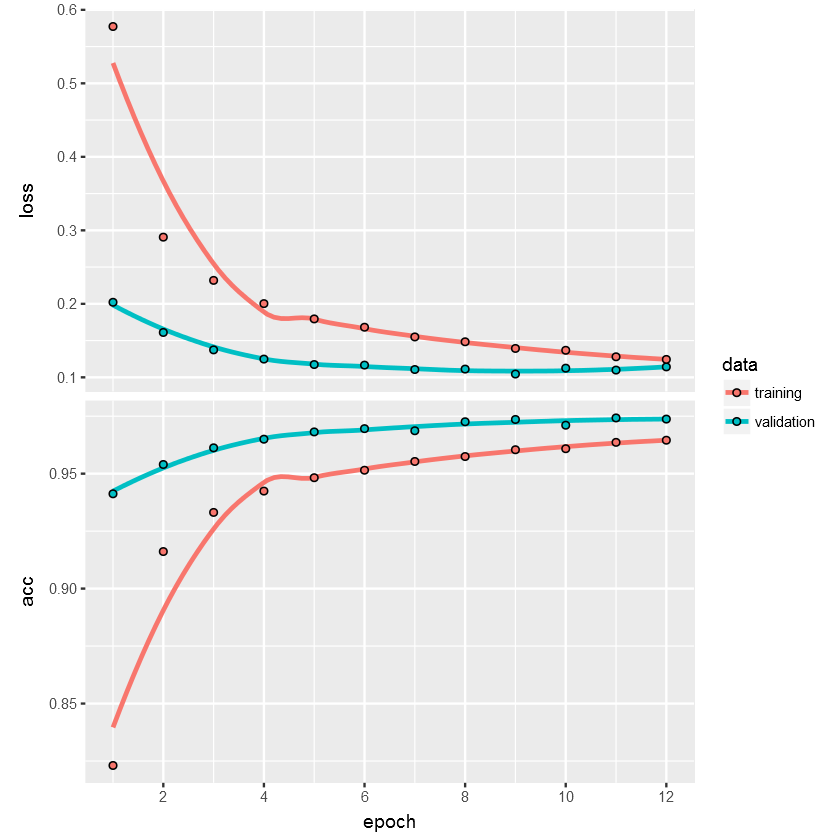

In [9]:
model %>% fit(
  x_train, y_train, 
  batch_size = 128, 
  epochs = 12, 
  verbose = 1,
  validation_split = 0.2
) %>% plot()

#### Evaluate the model

In [10]:
scores <- model %>% evaluate(x_test, y_test)

cat('Test loss:', scores[[1]], '\n')
cat('Test accuracy:', scores[[2]], '\n')

Test loss: 0.1090209 
Test accuracy: 0.972 


## Saving your model

Something we haven't talked about yet is saving your model. Neural networks can take a long time to run and so most of the time you'll want to save your final model so that you can load it back in for later sessions. 

The **keras** package provides a few options for saving a model:

### Save the whole model
The `save_model_hdf5()` function basically saves the entire model in a single file. It saves the model architecture (so you can re-compile), the model weights, and the state of the optimizer (so you can resume training where you left off). 

In [11]:
save_model_hdf5(model, "my_mnist_model.h5")

You can load the model later with `load_model_hdf5()`.

In [12]:
model <- load_model_hdf5("my_mnist_model.h5")

scores <- model %>% evaluate(x_test, y_test)
cat('Test loss:', scores[[1]], '\n')
cat('Test accuracy:', scores[[2]], '\n')

Test loss: 0.1090209 
Test accuracy: 0.972 


### Save the model weights only

The `save_model_weights_hdf5()` function just saves the model weights. 

In [13]:
save_model_weights_hdf5(model, "my_model_weights.h5")

You can load the weights later with `load_model_weights_hdf5()`. When you use `save_model_weights_hdf5()`, the architecture of the model is not saved, so you need to be careful when you reload the model. There are two main options: reloading the weights on top of the same model architecture you used to fit the weights, or reloading the weights on top of a new model architecture. The latter is useful if you want to keep certain layers of a model, but also modify or add new layers.

#### Reloading the weights on top of the same model architecture 

In cases where you want to use the same architecture as was used to create the model, you need to define the model the same way as you did when the weights were saved, and set the `by_name = FALSE` (the default) in `load_model_weights_hdf5()`. Note that layers that don't have weights are not taken into account in the topological ordering, so adding or removing layers is fine as long as they don't have weights. For example, removing the dropout layers in `model2` below has no effect (because we're not estimating the weights, just applying the saved ones).

Let's set up a new model called `model2` which is exactly the same as the previous model.

In [14]:
model2 <- keras_model_sequential() 
model2 %>% 
  layer_dense(units = 128, 
              activation = 'relu', 
              input_shape = c(784)) %>% 
  layer_dropout(rate = 0.4) %>% 
  layer_dense(units = 64, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 10, activation = 'softmax') %>% 
  compile(
  loss = 'categorical_crossentropy',
  optimizer = 'rmsprop',
  metrics = c('accuracy')
)

We now load the weights we previously saved (from the `model` object) and apply these to the new `model2`. We get exactly the same test accuracy as before (unsurprisingly!).

In [15]:
model2 %>% load_model_weights_hdf5("my_model_weights.h5", by_name = FALSE)

scores <- model2 %>% evaluate(x_test, y_test)
cat('Test loss:', scores[[1]], '\n')
cat('Test accuracy:', scores[[2]], '\n')

Test loss: 0.1090209 
Test accuracy: 0.972 


#### Reloading the weights on top of a different model architecture 

If you set `by_name = TRUE` in `load_model_weights_hdf5()`, weights are loaded into layers only if they share the same name. This can be useful for fine-tuning or transfer-learning models where some of the layers have changed. Doing that needs the Keras functional API, which will have a look at in the next lesson.

## Training a simple CNN on the MNIST data set

This section fits a simple CNN to the same MNIST data we used above. The section shows the way in which convolutional layers are implemented by Keras i.e. how to specify convolution filters and associated operations like max pooling. The example is taken from the RStudio Keras example pages [here](https://keras.rstudio.com/articles/examples/index.html).

### Data preparation

We start by doing exactly the same data preparation as in the previous example (we don't need to rerun this, but just to make it clearer what we're doing).

In [16]:
# separate out x and y values, and test and training data
x_train <- mnist$train$x
y_train <- mnist$train$y
x_test <- mnist$test$x
y_test <- mnist$test$y

# convert integers to floating point
x_train <- x_train / 255
x_test <- x_test / 255

# one-hot encoding
y_train <- to_categorical(y_train, 10)
y_test <- to_categorical(y_test, 10)

The first important difference between the CNN we fit here and the previous example is the dimensions of the input data. In the previous example, we "unravelled" or "flattened" each 28 x 28 image into a vector of length 784. The input data was a matrix with the same number of rows as input samples (60,000 in the training sample) and 784 columns. 

The dimension of the input for a 2-D CNN such as would be used for image classification is given by 
```
c(number of observations, image width in pixels, image height in pixels, number of values per pixel)
```
The number of values per pixel would usually be either 1 (grayscale images) or 3 (RGB images). In other words, each input observation (a grayscale image) is a 28 x 28 x 1 matrix (called a "tensor").

In [17]:
dim(x_train) <- c(nrow(x_train), 28, 28, 1) 
dim(x_test) <- c(nrow(x_test), 28, 28, 1)

We print out the number of images in the training and test sets below.

In [18]:
cat('x_train_shape:', dim(x_train), '\n')
cat(nrow(x_train), 'train samples\n')
cat(nrow(x_test), 'test samples\n')

x_train_shape: 60000 28 28 1 
60000 train samples
10000 test samples


### Model building

#### Defining the model
We use a sequential model as before. The only difference is that we are now stacking up convolutional layers.

In [19]:
model <- keras_model_sequential()

The main differences between the feedforward network in the previous section and the CNN we're now fitting is in the next code block. Note that the "dense" (fully connected) hidden layers (`layer_dense()`) have been replaced by a new layer type called `layer_conv_2d()`. There are two convolutional hidden layers.

* The first hidden layer must specify the shape of the input, as before. That is done using the `input_shape` argument.
* For any convolutional layer, we need to specify:
    * The number of convolution filters to use in that layer
    * The size of those filters (number of pixels wide, number of pixels high)
    * The activation function
* After any convolutional layer we *may* add a max pooling layer that reduces the dimensionality of the output of that layer (see spreadsheet explanation), or a dropout layer. Here, we have added dropout after layer 1 and max pooling after layer 2.
* The final hidden convolutional layer must be "flattened" before being connected to the output layer, using `layer_flatten()`. We could have added additional dense layers between the convolutional layers and the output layer if we wanted to.
    


In [20]:
model %>%
  layer_conv_2d(filters = 32,                      # number of convolution filters in conv layer 1
                kernel_size = c(3,3),              # use 3 x 3 convolution filter in conv layer 1
                input_shape = c(28, 28, 1)) %>%    # shape of input data
  layer_activation('relu') %>%                     # activation function in conv layer 1
  layer_dropout(rate = 0.20) %>%                   # apply 20% dropout after conv layer 1
  layer_conv_2d(filters = 64,                      # number of convolution filters in conv layer 2
                kernel_size = c(3,3)) %>%          # also use 3 x 3 filter in conv layer 2
  layer_activation('relu') %>%                     # activation function in conv layer 2
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%    # apply max pooling after conv layer 2
  layer_flatten() %>%                              # flatten output into a vector
  layer_dense(units = 10, activation = 'softmax')  # fully connected to output layer

#### Compiling the model

The remainder of the model building proceeds as before. We compile the model after adding our choice of loss function and optimizer, fit the model to training data, and evaluate it on the test data.

In [21]:
model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = 'rmsprop',
  metrics = c('accuracy')
)

#### Training the model

In [ ]:
model %>% fit(
  x_train, y_train,
  batch_size = 128,
  epochs = 12,
  verbose = 1,
  validation_split = 0.2
)

#### Evaluating the model on test data

In [ ]:
model %>% evaluate(x_test, y_test)

cat('Test loss:', scores[[1]], '\n')
cat('Test accuracy:', scores[[2]], '\n')